# I. **Import library**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **2. Load MNIST dataset**

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Prepare data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [11]:
# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# **3. Visualization**

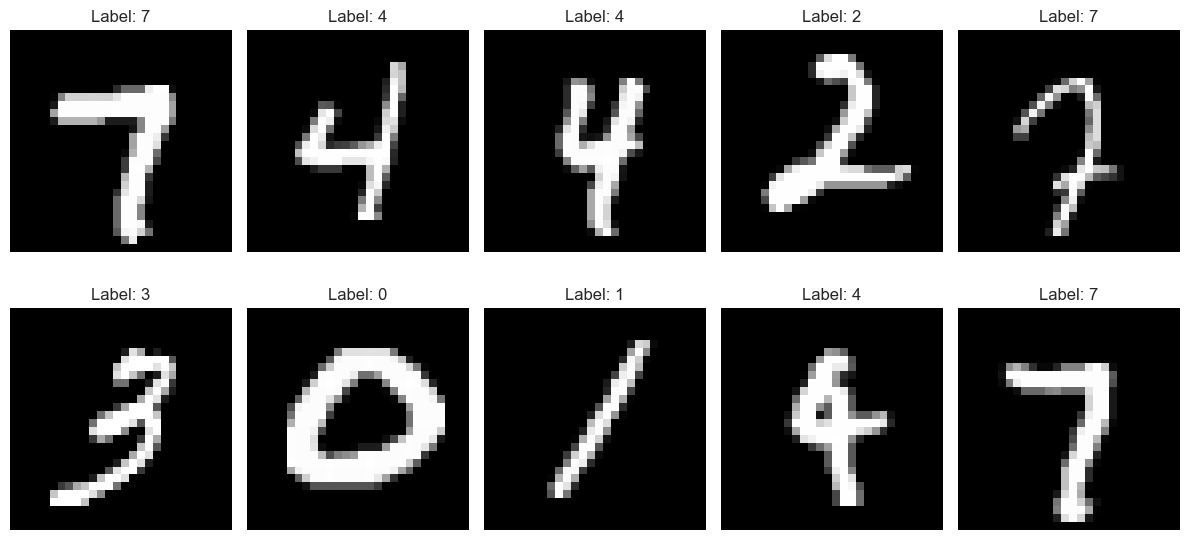

In [13]:
# Visualization
def plot_samples(loader):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, (img, label) in enumerate(loader):
        if i >= 10:
            break
        ax = axes[i//5, i%5]
        ax.imshow(img[0].squeeze(), cmap='gray')
        ax.set_title(f'Label: {label[0].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(train_loader)

# **4. Initialize Model**

In [14]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

In [15]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# **5. Configure DP-SGD**

In [16]:
# Privacy engine
privacy_engine = PrivacyEngine()

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=10,
    target_epsilon=1.0,
    target_delta=1e-5,
    max_grad_norm=1.0,
)

# **6. Prepare train and test functions**

In [17]:
# Train model with DP
def train(model, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return sum(losses) / len(losses)

In [18]:
# Test function
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return test_loss, accuracy

# **7. Train model**

In [19]:
# Train model
num_epochs = 10
train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    epsilon = privacy_engine.get_epsilon(delta=1e-5)
    print(f"ε: {epsilon:.2f}")

d:\anaconda3_env\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
d:\anaconda3_env\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320962
Train Epoch: 1 [5400/60000 (11%)]	Loss: 1.516438
Train Epoch: 1 [14400/60000 (21%)]	Loss: 1.020130
Train Epoch: 1 [17700/60000 (32%)]	Loss: 0.841209
Train Epoch: 1 [29600/60000 (43%)]	Loss: 1.254546
Train Epoch: 1 [32500/60000 (53%)]	Loss: 1.177119
Train Epoch: 1 [36600/60000 (64%)]	Loss: 0.982853
Train Epoch: 1 [44100/60000 (75%)]	Loss: 1.745925
Train Epoch: 1 [48800/60000 (85%)]	Loss: 1.531449
Train Epoch: 1 [54900/60000 (96%)]	Loss: 1.354365

Test set: Average loss: 0.0006, Accuracy: 8687/10000 (86.87%)

ε: 0.44
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.641718
Train Epoch: 2 [6600/60000 (11%)]	Loss: 1.479589
Train Epoch: 2 [10800/60000 (21%)]	Loss: 0.750894
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.013017
Train Epoch: 2 [24000/60000 (43%)]	Loss: 1.759115
Train Epoch: 2 [31500/60000 (53%)]	Loss: 2.455307
Train Epoch: 2 [45600/60000 (64%)]	Loss: 1.262108
Train Epoch: 2 [38500/60000 (75%)]	Loss: 1.720254
Train Epoch: 2 [47200/60000 (85%)]	Loss:

# **8. Display result**

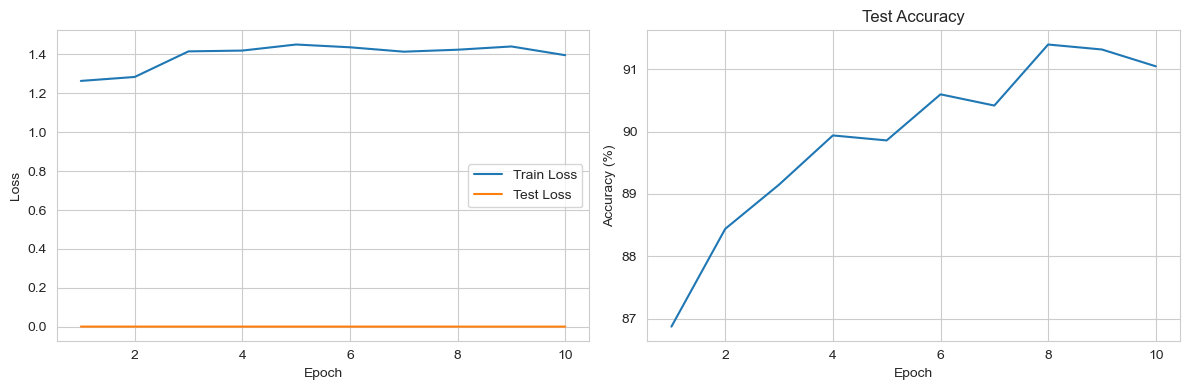

In [20]:
# Visualize resutl
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(range(1, num_epochs + 1), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()

In [21]:
# Final epsilon
final_epsilon = privacy_engine.get_epsilon(delta=1e-5)
print(f"Final ε: {final_epsilon:.2f}")

Final ε: 1.00


# **9. Save model**

In [23]:
torch.save(model.state_dict(), './model_params/dp_cnn.pt')

In [ ]:
# How to load model parameters?
# state_dict = torch.load('./model_params/dp_cnn.pt')
# new_model = CNN()
# new_model.load_state_dict(state_dict=state_dict)